In [1]:
import io
from logging import warning
from typing import Union, List
from site import PREFIXES
import warnings
import torch
import numpy as np
from tqdm import tqdm
import pandas as pd
from transformers import AutoTokenizer
import random
random.seed(42)
import re
import matplotlib.pyplot as plt
import copy

NAMES = [
    "Michael",
    "Christopher",
    "Jessica",
    "Matthew",
    "Ashley",
    "Jennifer",
    "Joshua",
    "Amanda",
    "Daniel",
    "David",
    "James",
    "Robert",
    "John",
    "Joseph",
    "Andrew",
    "Ryan",
    "Brandon",
    "Jason",
    "Justin",
    "Sarah",
    "William",
    "Jonathan",
    "Stephanie",
    "Brian",
    "Nicole",
    "Nicholas",
    "Anthony",
    "Heather",
    "Eric",
    "Elizabeth",
    "Adam",
    "Megan",
    "Melissa",
    "Kevin",
    "Steven",
    "Thomas",
    "Timothy",
    "Christina",
    "Kyle",
    "Rachel",
    "Laura",
    "Lauren",
    "Amber",
    "Brittany",
    "Danielle",
    "Richard",
    "Kimberly",
    "Jeffrey",
    "Amy",
    "Crystal",
    "Michelle",
    "Tiffany",
    "Jeremy",
    "Benjamin",
    "Mark",
    "Emily",
    "Aaron",
    "Charles",
    "Rebecca",
    "Jacob",
    "Stephen",
    "Patrick",
    "Sean",
    "Erin",
    "Jamie",
    "Kelly",
    "Samantha",
    "Nathan",
    "Sara",
    "Dustin",
    "Paul",
    "Angela",
    "Tyler",
    "Scott",
    "Katherine",
    "Andrea",
    "Gregory",
    "Erica",
    "Mary",
    "Travis",
    "Lisa",
    "Kenneth",
    "Bryan",
    "Lindsey",
    "Kristen",
    "Jose",
    "Alexander",
    "Jesse",
    "Katie",
    "Lindsay",
    "Shannon",
    "Vanessa",
    "Courtney",
    "Christine",
    "Alicia",
    "Cody",
    "Allison",
    "Bradley",
    "Samuel",
]

ABC_TEMPLATES = [
    "Then, [A], [B] and [C] went to the [PLACE]. [B] and [C] gave a [OBJECT] to [A]",
    "Afterwards [A], [B] and [C] went to the [PLACE]. [B] and [C] gave a [OBJECT] to [A]",
    "When [A], [B] and [C] arrived at the [PLACE], [B] and [C] gave a [OBJECT] to [A]",
    "Friends [A], [B] and [C] went to the [PLACE]. [B] and [C] gave a [OBJECT] to [A]",
]

BAC_TEMPLATES = [
    template.replace("[B]", "[A]", 1).replace("[A]", "[B]", 1)
    for template in ABC_TEMPLATES
]

BABA_TEMPLATES = [
    "Then, [B] and [A] went to the [PLACE]. [B] gave a [OBJECT] to [A]",
    "Then, [B] and [A] had a lot of fun at the [PLACE]. [B] gave a [OBJECT] to [A]",
    "Then, [B] and [A] were working at the [PLACE]. [B] decided to give a [OBJECT] to [A]",
    "Then, [B] and [A] were thinking about going to the [PLACE]. [B] wanted to give a [OBJECT] to [A]",
    "Then, [B] and [A] had a long argument, and afterwards [B] said to [A]",
    "After [B] and [A] went to the [PLACE], [B] gave a [OBJECT] to [A]",
    "When [B] and [A] got a [OBJECT] at the [PLACE], [B] decided to give it to [A]",
    "When [B] and [A] got a [OBJECT] at the [PLACE], [B] decided to give the [OBJECT] to [A]",
    "While [B] and [A] were working at the [PLACE], [B] gave a [OBJECT] to [A]",
    "While [B] and [A] were commuting to the [PLACE], [B] gave a [OBJECT] to [A]",
    "After the lunch, [B] and [A] went to the [PLACE]. [B] gave a [OBJECT] to [A]",
    "Afterwards, [B] and [A] went to the [PLACE]. [B] gave a [OBJECT] to [A]",
    "Then, [B] and [A] had a long argument. Afterwards [B] said to [A]",
    "The [PLACE] [B] and [A] went to had a [OBJECT]. [B] gave it to [A]",
    "Friends [B] and [A] found a [OBJECT] at the [PLACE]. [B] gave it to [A]",
]

BABA_LONG_TEMPLATES = [
    "Then in the morning, [B] and [A] went to the [PLACE]. [B] gave a [OBJECT] to [A]",
    "Then in the morning, [B] and [A] had a lot of fun at the [PLACE]. [B] gave a [OBJECT] to [A]",
    "Then in the morning, [B] and [A] were working at the [PLACE]. [B] decided to give a [OBJECT] to [A]",
    "Then in the morning, [B] and [A] were thinking about going to the [PLACE]. [B] wanted to give a [OBJECT] to [A]",
    "Then in the morning, [B] and [A] had a long argument, and afterwards [B] said to [A]",
    "After taking a long break [B] and [A] went to the [PLACE], [B] gave a [OBJECT] to [A]",
    "When soon afterwards [B] and [A] got a [OBJECT] at the [PLACE], [B] decided to give it to [A]",
    "When soon afterwards [B] and [A] got a [OBJECT] at the [PLACE], [B] decided to give the [OBJECT] to [A]",
    "While spending time together [B] and [A] were working at the [PLACE], [B] gave a [OBJECT] to [A]",
    "While spending time together [B] and [A] were commuting to the [PLACE], [B] gave a [OBJECT] to [A]",
    "After the lunch in the afternoon, [B] and [A] went to the [PLACE]. [B] gave a [OBJECT] to [A]",
    "Afterwards, while spending time together [B] and [A] went to the [PLACE]. [B] gave a [OBJECT] to [A]",
    "Then in the morning afterwards, [B] and [A] had a long argument. Afterwards [B] said to [A]",
    "The local big [PLACE] [B] and [A] went to had a [OBJECT]. [B] gave it to [A]",
    "Friends separated at birth [B] and [A] found a [OBJECT] at the [PLACE]. [B] gave it to [A]",
]

BABA_LATE_IOS = [
    "Then, [B] and [A] went to the [PLACE]. [B] gave a [OBJECT] to [A]",
    "Then, [B] and [A] had a lot of fun at the [PLACE]. [B] gave a [OBJECT] to [A]",
    "Then, [B] and [A] were working at the [PLACE]. [B] decided to give a [OBJECT] to [A]",
    "Then, [B] and [A] were thinking about going to the [PLACE]. [B] wanted to give a [OBJECT] to [A]",
    "Then, [B] and [A] had a long argument and after that [B] said to [A]",
    "After the lunch, [B] and [A] went to the [PLACE]. [B] gave a [OBJECT] to [A]",
    "Afterwards, [B] and [A] went to the [PLACE]. [B] gave a [OBJECT] to [A]",
    "Then, [B] and [A] had a long argument. Afterwards [B] said to [A]",
]

BABA_EARLY_IOS = [
    "Then [B] and [A] went to the [PLACE], and [B] gave a [OBJECT] to [A]",
    "Then [B] and [A] had a lot of fun at the [PLACE], and [B] gave a [OBJECT] to [A]",
    "Then [B] and [A] were working at the [PLACE], and [B] decided to give a [OBJECT] to [A]",
    "Then [B] and [A] were thinking about going to the [PLACE], and [B] wanted to give a [OBJECT] to [A]",
    "Then [B] and [A] had a long argument, and after that [B] said to [A]",
    "After the lunch [B] and [A] went to the [PLACE], and [B] gave a [OBJECT] to [A]",
    "Afterwards [B] and [A] went to the [PLACE], and [B] gave a [OBJECT] to [A]",
    "Then [B] and [A] had a long argument, and afterwards [B] said to [A]",
]

TEMPLATES_VARIED_MIDDLE = [
    "",
]

# no end of texts, GPT-2 small wasn't trained this way (ask Arthur)
# warnings.warn("Adding end of text prefixes!")
# for TEMPLATES in [BABA_TEMPLATES, BABA_EARLY_IOS, BABA_LATE_IOS]:
#     for i in range(len(TEMPLATES)):
#         TEMPLATES[i] = "<|endoftext|>" + TEMPLATES[i]

ABBA_TEMPLATES = BABA_TEMPLATES[:]
ABBA_LATE_IOS = BABA_LATE_IOS[:]
ABBA_EARLY_IOS = BABA_EARLY_IOS[:]

for TEMPLATES in [ABBA_TEMPLATES, ABBA_LATE_IOS, ABBA_EARLY_IOS]:
    for i in range(len(TEMPLATES)):
        first_clause = True
        for j in range(1, len(TEMPLATES[i]) - 1):
            if TEMPLATES[i][j - 1 : j + 2] == "[B]" and first_clause:
                TEMPLATES[i] = TEMPLATES[i][:j] + "A" + TEMPLATES[i][j + 1 :]
            elif TEMPLATES[i][j - 1 : j + 2] == "[A]" and first_clause:
                first_clause = False
                TEMPLATES[i] = TEMPLATES[i][:j] + "B" + TEMPLATES[i][j + 1 :]

VERBS = [" tried", " said", " decided", " wanted", " gave"]
PLACES = [
    "store",
    "garden",
    "restaurant",
    "school",
    "hospital",
    "office",
    "house",
    "station",
]
OBJECTS = [
    "ring",
    "kiss",
    "bone",
    "basketball",
    "computer",
    "necklace",
    "drink",
    "snack",
]

ANIMALS = [
    "dog",
    "cat",
    "snake",
    "elephant",
    "beetle",
    "hippo",
    "giraffe",
    "tiger",
    "husky",
    "lion",
    "panther",
    "whale",
    "dolphin",
    "beaver",
    "rabbit",
    "fox",
    "lamb",
    "ferret",
]


def multiple_replace(dict, text):
    # from: https://stackoverflow.com/questions/15175142/how-can-i-do-multiple-substitutions-using-regex
    # Create a regular expression from the dictionary keys
    regex = re.compile("(%s)" % "|".join(map(re.escape, dict.keys())))

    # For each match, look-up corresponding value in dictionary
    return regex.sub(lambda mo: dict[mo.string[mo.start() : mo.end()]], text)


def iter_sample_fast(iterable, samplesize):
    results = []
    try:
        for _ in range(samplesize):
            results.append(next(iterable))
    except StopIteration:
        raise ValueError("Sample larger than population.")
    random.shuffle(results)

    return results


NOUNS_DICT = NOUNS_DICT = {"[PLACE]": PLACES, "[OBJECT]": OBJECTS}


def gen_prompt_uniform(
    templates, names, nouns_dict, N, symmetric, prefixes=None, abc=False
):
    nb_gen = 0
    ioi_prompts = []
    while nb_gen < N:
        temp = random.choice(templates)
        temp_id = templates.index(temp)
        name_1 = ""
        name_2 = ""
        name_3 = ""
        while len(set([name_1, name_2, name_3])) < 3:
            name_1 = random.choice(names)
            name_2 = random.choice(names)
            name_3 = random.choice(names)

        nouns = {}
        ioi_prompt = {}
        for k in nouns_dict:
            nouns[k] = random.choice(nouns_dict[k])
            ioi_prompt[k] = nouns[k]
        prompt = temp
        for k in nouns_dict:
            prompt = prompt.replace(k, nouns[k])

        if prefixes is not None:
            L = random.randint(30, 40)
            pref = ".".join(random.choice(prefixes).split(".")[:L])
            pref += "<|endoftext|>"
        else:
            pref = ""

        prompt1 = prompt.replace("[A]", name_1)
        prompt1 = prompt1.replace("[B]", name_2)
        if abc:
            prompt1 = prompt1.replace("[C]", name_3)
        prompt1 = pref + prompt1
        ioi_prompt["text"] = prompt1
        ioi_prompt["IO"] = name_1
        ioi_prompt["S"] = name_2
        ioi_prompt["TEMPLATE_IDX"] = temp_id
        ioi_prompts.append(ioi_prompt)
        if abc:
            ioi_prompts[-1]["C"] = name_3

        nb_gen += 1

        if symmetric and nb_gen < N:
            prompt2 = prompt.replace("[A]", name_2)
            prompt2 = prompt2.replace("[B]", name_1)
            prompt2 = pref + prompt2
            ioi_prompts.append(
                {"text": prompt2, "IO": name_2, "S": name_1, "TEMPLATE_IDX": temp_id}
            )
            nb_gen += 1
    return ioi_prompts


def gen_flipped_prompts(prompts, names, flip=("S2", "IO")):
    flipped_prompts = []

    for prompt in prompts:
        t = prompt["text"].split(" ")
        prompt = prompt.copy()
        if flip[0] == "S2":
            if flip[1] == "IO":
                t[len(t) - t[::-1].index(prompt["S"]) - 1] = prompt["IO"]
                temp = prompt["IO"]
                prompt["IO"] = prompt["S"]
                prompt["S"] = temp
            elif flip[1] == "RAND":
                rand_name = names[np.random.randint(len(names))]
                while rand_name == prompt["IO"] or rand_name == prompt["S"]:
                    rand_name = names[np.random.randint(len(names))]
                t[len(t) - t[::-1].index(prompt["S"]) - 1] = rand_name
            else:
                raise ValueError("Invalid flip[1] value")

        elif flip[0] == "IO":
            if flip[1] == "RAND":
                rand_name = names[np.random.randint(len(names))]
                while rand_name == prompt["IO"] or rand_name == prompt["S"]:
                    rand_name = names[np.random.randint(len(names))]

                t[t.index(prompt["IO"])] = rand_name
                t[t.index(prompt["IO"])] = rand_name
                prompt["IO"] = rand_name
            elif flip[1] == "ANIMAL":
                rand_animal = ANIMALS[np.random.randint(len(ANIMALS))]
                t[t.index(prompt["IO"])] = rand_animal
                prompt["IO"] = rand_animal
                # print(t)
            elif flip[1] == "S1":
                io_index = t.index(prompt["IO"])
                s1_index = t.index(prompt["S"])
                io = t[io_index]
                s1 = t[s1_index]
                t[io_index] = s1
                t[s1_index] = io
            else:
                raise ValueError("Invalid flip[1] value")

        elif flip[0] in ["S", "S1"]:
            if flip[1] == "ANIMAL":
                new_s = ANIMALS[np.random.randint(len(ANIMALS))]
            if flip[1] == "RAND":
                new_s = names[np.random.randint(len(names))]
            t[t.index(prompt["S"])] = new_s
            if flip[0] == "S":
                t[len(t) - t[::-1].index(prompt["S"]) - 1] = new_s
                prompt["S"] = new_s
        elif flip[0] == "END":
            if flip[1] == "S":
                t[len(t) - t[::-1].index(prompt["IO"]) - 1] = prompt["S"]
        elif flip[0] == "PUNC":
            n = []

            for i, word in enumerate(t):
                if "." in word:
                    n.append(word[:-1])
                    n.append(".")
                elif "," in word:
                    n.append(word[:-1])
                    n.append(",")
                else:
                    n.append(word)

            if flip[1] == "NONE":
                if "." in n:
                    n[n.index(".")] = ""
                elif "," in n:
                    n[len(n) - n[::-1].index(",") - 1] = ""

            while "" in n:
                n.remove("")

            while "," in n:
                n[n.index(",") - 1] += ","
                n.remove(",")

            while "." in n:
                n[n.index(".") - 1] += "."
                n.remove(".")

            t = n

        elif flip[0] == "C2":
            if flip[1] == "A":
                t[len(t) - t[::-1].index(prompt["C"]) - 1] = prompt["A"]
        elif flip[0] == "S+1":
            if t[t.index(prompt["S"]) + 1] == "and":
                t[t.index(prompt["S"]) + 1] = [
                    "with one friend named",
                    "accompanied by",
                ][np.random.randint(2)]
            else:
                t[t.index(prompt["S"]) + 1] = (
                    t[t.index(prompt["S"])]
                    + ", after a great day, "
                    + t[t.index(prompt["S"]) + 1]
                )
                del t[t.index(prompt["S"])]
        else:
            raise ValueError(f"Invalid flipper {flip[0]}")

        if "IO" in prompt:
            prompt["text"] = " ".join(t)
            flipped_prompts.append(prompt)
        else:
            flipped_prompts.append(
                {
                    "A": prompt["A"],
                    "B": prompt["B"],
                    "C": prompt["C"],
                    "text": " ".join(t),
                }
            )

    return flipped_prompts



def get_name_idxs(prompts, tokenizer, idx_types=["IO", "S", "S2"], prepend_bos=False):
    name_idx_dict = dict((idx_type, []) for idx_type in idx_types)
    double_s2 = False
    for prompt in prompts:
        t = prompt["text"].split(" ")
        toks = tokenizer.tokenize(" ".join(t[:-1]))
        for idx_type in idx_types:
            if "2" in idx_type:
                idx = (
                    len(toks)
                    - toks[::-1].index(
                        tokenizer.tokenize(" " + prompt[idx_type[:-1]])[0]
                    )
                    - 1
                )
            else:
                idx = toks.index(tokenizer.tokenize(" " + prompt[idx_type])[0])
            name_idx_dict[idx_type].append(idx)
        if "S" in idx_types and "S2" in idx_types:
            if name_idx_dict["S"][-1] == name_idx_dict["S2"][-1]:
                double_s2 = True
    if double_s2:
        warnings.warn("S2 index has been computed as the same for S and S2")

    return [
        int(prepend_bos) + torch.tensor(name_idx_dict[idx_type])
        for idx_type in idx_types
    ]


def get_word_idxs(prompts, word_list, tokenizer):
    idxs = []
    tokenized_words = [
        tokenizer.decode(tokenizer(word)["input_ids"][0]) for word in word_list
    ]
    for pr_idx, prompt in enumerate(prompts):
        toks = [
            tokenizer.decode(t)
            for t in tokenizer(prompt["text"], return_tensors="pt", padding=True)[
                "input_ids"
            ][0]
        ]
        idx = None
        for i, w_tok in enumerate(tokenized_words):
            if word_list[i] in prompt["text"]:
                try:
                    idx = toks.index(w_tok)
                    if toks.count(w_tok) > 1:
                        idx = len(toks) - toks[::-1].index(w_tok) - 1
                except:
                    idx = toks.index(w_tok)
                    # raise ValueError(toks, w_tok, prompt["text"])
        if idx is None:
            raise ValueError(f"Word {word_list} and {i} not found {prompt}")
        idxs.append(idx)
    return torch.tensor(idxs)


def get_end_idxs(prompts, tokenizer, name_tok_len=1, prepend_bos=False, toks=None):
    # toks = torch.Tensor(tokenizer([prompt["text"] for prompt in prompts], padding=True).input_ids).type(torch.int)
    relevant_idx = int(prepend_bos)

    pad_token_id = tokenizer.pad_token_id

    end_idxs_raw = []
    for i in range(toks.shape[0]):
        if pad_token_id not in toks[i][1:]:
            end_idxs_raw.append(toks.shape[1])
            continue
        nonzers = (toks[i] == pad_token_id).nonzero()
        try:
            nonzers = nonzers[relevant_idx]
        except:
            print(toks[i])
            print(nonzers)
            print(relevant_idx)
            print(i)
            raise ValueError("Something went wrong")
        nonzers = nonzers[0]
        nonzers = nonzers.item()
        end_idxs_raw.append(nonzers)
    end_idxs = torch.tensor(end_idxs_raw)
    end_idxs = end_idxs - 1 - name_tok_len

    for i in range(toks.shape[0]):
        assert toks[i][end_idxs[i] + 1] != 0 and (
            toks.shape[1] == end_idxs[i] + 2 or toks[i][end_idxs[i] + 2] == pad_token_id
        ), (
            toks[i],
            end_idxs[i],
            toks[i].shape,
            "the END idxs aren't properly formatted",
        )

    return end_idxs


import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

ALL_SEM = [
    "S",
    "IO",
    "S2",
    "end",
    "S+1",
    "and",
]


def get_idx_dict(ioi_prompts, tokenizer, prepend_bos=False, toks=None):
    (IO_idxs, S_idxs, S2_idxs,) = get_name_idxs(
        ioi_prompts,
        tokenizer,
        idx_types=["IO", "S", "S2"],
        prepend_bos=prepend_bos,
    )

    end_idxs = get_end_idxs(
        ioi_prompts,
        tokenizer,
        name_tok_len=1,
        prepend_bos=prepend_bos,
        toks=toks,
    )

    punct_idxs = get_word_idxs(ioi_prompts, [",", "."], tokenizer)

    return {
        "IO": IO_idxs,
        "IO-1": IO_idxs - 1,
        "IO+1": IO_idxs + 1,
        "S": S_idxs,
        "S-1": S_idxs - 1,
        "S+1": S_idxs + 1,
        "S2": S2_idxs,
        "end": end_idxs,
        "starts": torch.zeros_like(end_idxs),
        "punct": punct_idxs,
    }


PREFIXES = [
    "             Afterwards,",
    "            Two friends met at a bar. Then,",
    "  After a long day,",
    "  After a long day,",
    "    Then,",
    "         Then,",
]


def flip_prefixes(ioi_prompts):
    ioi_prompts = copy.deepcopy(ioi_prompts)
    for prompt in ioi_prompts:
        if prompt["text"].startswith("The "):
            prompt["text"] = "After the lunch, the" + prompt["text"][4:]
        else:
            io_idx = prompt["text"].index(prompt["IO"])
            s_idx = prompt["text"].index(prompt["S"])
            first_idx = min(io_idx, s_idx)
            prompt["text"] = random.choice(PREFIXES) + " " + prompt["text"][first_idx:]

    return ioi_prompts


def flip_names(ioi_prompts):
    ioi_prompts = copy.deepcopy(ioi_prompts)
    for prompt in ioi_prompts:
        punct_idx = max(
            [i for i, x in enumerate(list(prompt["text"])) if x in [",", "."]]
        )
        io = prompt["IO"]
        s = prompt["S"]
        prompt["text"] = (
            prompt["text"][:punct_idx]
            .replace(io, "#")
            .replace(s, "@")
            .replace("#", s)
            .replace("@", io)
        ) + prompt["text"][punct_idx:]
        # print(prompt["text"])

    return ioi_prompts


class IOIDataset:
    def __init__(
        self,
        prompt_type: Union[
            str, List[str]
        ],  # if list, then it will be a list of templates
        N=500,
        tokenizer=None,
        prompts=None,
        symmetric=False,
        prefixes=None,
        nb_templates=None,
        ioi_prompts_for_word_idxs=None,
        prepend_bos=False,
        manual_word_idx=None,
    ):

        if not (
            N == 1
            or prepend_bos == False
            or tokenizer.bos_token_id == tokenizer.eos_token_id
        ):
            warnings.warn(
                "Probably word_idx will be calculated incorrectly due to this formatting"
            )
        assert not (symmetric and prompt_type == "ABC")
        assert (
            (prompts is not None) or (not symmetric) or (N % 2 == 0)
        ), f"{symmetric} {N}"
        assert nb_templates is None or (nb_templates % 2 == 0 or prompt_type != "mixed")
        self.prompt_type = prompt_type

        if nb_templates is None:
            nb_templates = len(BABA_TEMPLATES)

        if prompt_type == "ABBA":
            self.templates = ABBA_TEMPLATES[:nb_templates].copy()
        elif prompt_type == "BABA":
            self.templates = BABA_TEMPLATES[:nb_templates].copy()
        elif prompt_type == "mixed":
            self.templates = (
                BABA_TEMPLATES[: nb_templates // 2].copy()
                + ABBA_TEMPLATES[: nb_templates // 2].copy()
            )
            random.shuffle(self.templates)
        elif prompt_type == "ABC":
            self.templates = ABC_TEMPLATES[:nb_templates].copy()
        elif prompt_type == "BAC":
            self.templates = BAC_TEMPLATES[:nb_templates].copy()
        elif prompt_type == "ABC mixed":
            self.templates = (
                ABC_TEMPLATES[: nb_templates // 2].copy()
                + BAC_TEMPLATES[: nb_templates // 2].copy()
            )
            random.shuffle(self.templates)
        elif isinstance(prompt_type, list):
            self.templates = prompt_type
        else:
            raise ValueError(prompt_type)

        if tokenizer is None:
            self.tokenizer = AutoTokenizer.from_pretrained("gpt2")
            self.tokenizer.pad_token = self.tokenizer.eos_token
        else:
            self.tokenizer = tokenizer

        self.prefixes = prefixes
        self.prompt_type = prompt_type
        if prompts is None:
            self.ioi_prompts = gen_prompt_uniform(  # a list of dict of the form {"text": "Alice and Bob bla bla. Bob gave bla to Alice", "IO": "Alice", "S": "Bob"}
                self.templates,
                NAMES,
                nouns_dict={"[PLACE]": PLACES, "[OBJECT]": OBJECTS},
                N=N,
                symmetric=symmetric,
                prefixes=self.prefixes,
                abc=(prompt_type in ["ABC", "ABC mixed", "BAC"]),
            )
        else:
            assert N == len(prompts), f"{N} and {len(prompts)}"
            self.ioi_prompts = prompts

        all_ids = [prompt["TEMPLATE_IDX"] for prompt in self.ioi_prompts]
        all_ids_ar = np.array(all_ids)
        self.groups = []
        for id in list(set(all_ids)):
            self.groups.append(np.where(all_ids_ar == id)[0])

        small_groups = []
        for group in self.groups:
            if len(group) < 5:
                small_groups.append(len(group))
        if len(small_groups) > 0:
            warnings.warn(
                f"Some groups have less than 5 prompts, they have lengths {small_groups}"
            )

        self.sentences = [
            prompt["text"] for prompt in self.ioi_prompts
        ]  # a list of strings. Renamed as this should NOT be forward passed

        self.templates_by_prompt = []  # for each prompt if it's ABBA or BABA
        for i in range(N):
            if self.sentences[i].index(self.ioi_prompts[i]["IO"]) < self.sentences[
                i
            ].index(self.ioi_prompts[i]["S"]):
                self.templates_by_prompt.append("ABBA")
            else:
                self.templates_by_prompt.append("BABA")

        # print(self.ioi_prompts, "that's that")
        texts = [
            (self.tokenizer.bos_token if prepend_bos else "") + prompt["text"]
            for prompt in self.ioi_prompts
        ]
        self.toks = torch.Tensor(self.tokenizer(texts, padding=True).input_ids).type(
            torch.int
        )

        if ioi_prompts_for_word_idxs is None:
            ioi_prompts_for_word_idxs = self.ioi_prompts
        self.word_idx = get_idx_dict(
            ioi_prompts_for_word_idxs,
            self.tokenizer,
            prepend_bos=prepend_bos,
            toks=self.toks,
        )
        self.prepend_bos = prepend_bos
        if manual_word_idx is not None:
            self.word_idx = manual_word_idx

        self.sem_tok_idx = {
            k: v for k, v in self.word_idx.items() if k in ALL_SEM
        }
        self.N = N
        self.max_len = max(
            [
                len(self.tokenizer(prompt["text"]).input_ids)
                for prompt in self.ioi_prompts
            ]
        )

        self.io_tokenIDs = [
            self.tokenizer.encode(" " + prompt["IO"])[0] for prompt in self.ioi_prompts
        ]
        self.s_tokenIDs = [
            self.tokenizer.encode(" " + prompt["S"])[0] for prompt in self.ioi_prompts
        ]

        self.tokenized_prompts = []

        for i in range(self.N):
            self.tokenized_prompts.append(
                "|".join([self.tokenizer.decode(tok) for tok in self.toks[i]])
            )

    @classmethod
    def construct_from_ioi_prompts_metadata(cls, templates, ioi_prompts_data, **kwargs):

        prompts = []
        for metadata in ioi_prompts_data:
            cur_template = templates[metadata["TEMPLATE_IDX"]]
            prompts.append(metadata)
            prompts[-1]["text"] = (
                cur_template.replace("[A]", metadata["IO"])
                .replace("[B]", metadata["S"])
                .replace("[PLACE]", metadata["[PLACE]"])
                .replace("[OBJECT]", metadata["[OBJECT]"])
            )
            # prompts[-1]["[PLACE]"] = metadata["[PLACE]"]
            # prompts[-1]["[OBJECT]"] = metadata["[OBJECT]"]
        return IOIDataset(prompt_type=templates, prompts=prompts, **kwargs)

    def gen_flipped_prompts(self, flip):
        assert isinstance(flip, tuple) or flip in [
            "prefix",
        ], f"{flip} is not a tuple. Probably change to ('IO', 'RAND') or equivalent?"

        if flip == "prefix":
            flipped_prompts = flip_prefixes(self.ioi_prompts)
        else:
            if flip in [("IO", "S1"), ("S", "IO")]:
                flipped_prompts = gen_flipped_prompts(
                    self.ioi_prompts,
                    None,
                    flip,
                )
            elif flip == ("S2", "IO"):
                flipped_prompts = gen_flipped_prompts(
                    self.ioi_prompts,
                    None,
                    flip,
                )

            else:
                assert flip[1] == "RAND" and flip[0] in [
                    "S",
                    "RAND",
                    "S2",
                    "IO",
                    "S1",
                    "S+1",
                ], flip
                flipped_prompts = gen_flipped_prompts(self.ioi_prompts, NAMES, flip)

        flipped_ioi_dataset = IOIDataset(
            prompt_type=self.prompt_type,
            N=self.N,
            tokenizer=self.tokenizer,
            prompts=flipped_prompts,
            prefixes=self.prefixes,
            ioi_prompts_for_word_idxs=flipped_prompts if flip[0] == "RAND" else None,
            prepend_bos=self.prepend_bos,
            manual_word_idx=self.word_idx,
        )
        return flipped_ioi_dataset

    def copy(self):
        copy_ioi_dataset = IOIDataset(
            prompt_type=self.prompt_type,
            N=self.N,
            tokenizer=self.tokenizer,
            prompts=self.ioi_prompts.copy(),
            prefixes=self.prefixes.copy()
            if self.prefixes is not None
            else self.prefixes,
            ioi_prompts_for_word_idxs=self.ioi_prompts.copy(),
        )
        return copy_ioi_dataset

    def __getitem__(self, key):
        sliced_prompts = self.ioi_prompts[key]
        sliced_dataset = IOIDataset(
            prompt_type=self.prompt_type,
            N=len(sliced_prompts),
            tokenizer=self.tokenizer,
            prompts=sliced_prompts,
            prefixes=self.prefixes,
            prepend_bos=self.prepend_bos,
        )
        return sliced_dataset

    def __setitem__(self, key, value):
        raise NotImplementedError()

    def __delitem__(self, key):
        raise NotImplementedError()

    def __len__(self):
        return self.N

    def tokenized_prompts(self):
        return self.toks


# tests that the templates work as intended
assert len(BABA_EARLY_IOS) == len(BABA_LATE_IOS), (len(BABA_EARLY_IOS), len(BABA_LATE_IOS))
for i in range(len(BABA_EARLY_IOS)):
    d1 = IOIDataset(N=1, prompt_type=BABA_EARLY_IOS[i:i+1])
    d2 = IOIDataset(N=1, prompt_type=BABA_LATE_IOS[i:i+1])
    for tok in ["IO", "S"]: # occur one earlier and one later
        assert d1.word_idx[tok] + 1 == d2.word_idx[tok], (d1.word_idx[tok], d2.word_idx[tok])
    for tok in ["S2"]:
        assert d1.word_idx[tok] == d2.word_idx[tok], (d1.word_idx[tok], d2.word_idx[tok])

/usr/local/lib/python3.10/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/tmp/ipykernel_40563/3899178729.py:742: UserWarning: Some groups have less than 5 prompts, they have lengths [1]
  warnings.warn(
2025-05-06 11:42:35.092751: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-06 11:42:35.111380: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered

In [2]:
%pip install git+https://github.com/neelnanda-io/TransformerLens.git
from transformer_lens import HookedTransformer
import torch
torch.set_grad_enabled(False)  # turn automatic differentiation off to save mem

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/neelnanda-io/TransformerLens.git to /tmp/pip-req-build-zi4ily4b
  Running command git clone --filter=blob:none --quiet https://github.com/neelnanda-io/TransformerLens.git /tmp/pip-req-build-zi4ily4b
  Resolved https://github.com/neelnanda-io/TransformerLens.git to commit 47fe15666017d1b507bfebeefd877dbc428d8463
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.


/csse/users/rha192/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /csse/users/rha192/.local/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warn(f"Failed to load image Python extension: {e}")


In [3]:
teacher_str = "gpt2-small"
student_str = "distillgpt2"

teacher = HookedTransformer.from_pretrained(
    teacher_str,
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
)

student = HookedTransformer.from_pretrained(
    student_str,
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Loaded pretrained model gpt2-small into HookedTransformer
Loaded pretrained model distillgpt2 into HookedTransformer


In [4]:
N = 100
ioi_dataset = IOIDataset(
    prompt_type="mixed",
    N=N,
    tokenizer=teacher.tokenizer,
    prepend_bos=False,
)

print(f"Here are two of the prompts from the dataset: {ioi_dataset.sentences[:2]}")

Here are two of the prompts from the dataset: ['Then, Kimberly and Tiffany had a long argument, and afterwards Kimberly said to Tiffany', 'Then, Joshua and Allison had a lot of fun at the restaurant. Joshua gave a bone to Allison']


/tmp/ipykernel_40563/3899178729.py:742: UserWarning: Some groups have less than 5 prompts, they have lengths [4]
  warnings.warn(


In [5]:
abc_dataset = (
    ioi_dataset.gen_flipped_prompts(("IO", "RAND"))
    .gen_flipped_prompts(("S", "RAND"))
    .gen_flipped_prompts(("S1", "RAND"))
)

print(f"Here are two of the prompts from the corrupted dataset: {abc_dataset.sentences[:2]}")

/tmp/ipykernel_40563/3899178729.py:742: UserWarning: Some groups have less than 5 prompts, they have lengths [4]
  warnings.warn(
/tmp/ipykernel_40563/3899178729.py:485: UserWarning: S2 index has been computed as the same for S and S2
  warnings.warn("S2 index has been computed as the same for S and S2")


Here are two of the prompts from the corrupted dataset: ['Then, Rachel and Brittany had a long argument, and afterwards Tyler said to Brittany', 'Then, Sarah and Stephanie had a lot of fun at the restaurant. Kevin gave a bone to Stephanie']


In [6]:
prompts = ioi_dataset.ioi_prompts
prompts_2 = abc_dataset.ioi_prompts

In [7]:
prompts

[{'[PLACE]': 'restaurant',
  '[OBJECT]': 'snack',
  'text': 'Then, Kimberly and Tiffany had a long argument, and afterwards Kimberly said to Tiffany',
  'IO': 'Tiffany',
  'S': 'Kimberly',
  'TEMPLATE_IDX': 9},
 {'[PLACE]': 'restaurant',
  '[OBJECT]': 'bone',
  'text': 'Then, Joshua and Allison had a lot of fun at the restaurant. Joshua gave a bone to Allison',
  'IO': 'Allison',
  'S': 'Joshua',
  'TEMPLATE_IDX': 1},
 {'[PLACE]': 'garden',
  '[OBJECT]': 'drink',
  'text': 'Then, Jesse and Mark were thinking about going to the garden. Mark wanted to give a drink to Jesse',
  'IO': 'Jesse',
  'S': 'Mark',
  'TEMPLATE_IDX': 12},
 {'[PLACE]': 'hospital',
  '[OBJECT]': 'ring',
  'text': 'After Jacob and Gregory went to the hospital, Jacob gave a ring to Gregory',
  'IO': 'Gregory',
  'S': 'Jacob',
  'TEMPLATE_IDX': 6},
 {'[PLACE]': 'hospital',
  '[OBJECT]': 'necklace',
  'text': 'Then, Andrew and Courtney were working at the hospital. Andrew decided to give a necklace to Courtney',
  'IO':

In [8]:
prompts_text=[prompt['text'] for prompt in prompts]
prompts_text_2=[prompt['text'] for prompt in prompts_2]

In [9]:
prompts_text[:5]

['Then, Kimberly and Tiffany had a long argument, and afterwards Kimberly said to Tiffany',
 'Then, Joshua and Allison had a lot of fun at the restaurant. Joshua gave a bone to Allison',
 'Then, Jesse and Mark were thinking about going to the garden. Mark wanted to give a drink to Jesse',
 'After Jacob and Gregory went to the hospital, Jacob gave a ring to Gregory',
 'Then, Andrew and Courtney were working at the hospital. Andrew decided to give a necklace to Courtney']

In [10]:
tokens_t = teacher.to_tokens(prompts_text, prepend_bos=True)
tokens_s = student.to_tokens(prompts_text, prepend_bos=True)
# tokens = tokens.cuda() # Move the tokens to the GPU

original_logits_t, local_cache_t = teacher.run_with_cache(tokens_t)
original_logits_s, local_cache_s = student.run_with_cache(tokens_s)

# Node Influence Calculation

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.notebook as tqdm
import random
from pathlib import Path
# import plotly.express as px
from torch.utils.data import DataLoader

from jaxtyping import Float, Int
from typing import List, Union, Optional
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML

import pickle

import matplotlib.pyplot as plt
import statistics

import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

torch.set_grad_enabled(False)

In [12]:
import torch
import numpy as np

class Dataset:
    def __init__(self, prompts, tokenizer, prepend_bos=False):
        self.prompts = prompts
        self.tokenizer = tokenizer
        self.N = len(prompts)
        self.prepend_bos = prepend_bos

        texts = [
            (self.tokenizer.bos_token if self.prepend_bos else "") + prompt["text"]
            for prompt in self.prompts
        ]

        # padding dynamically to longest sequence
        tokenized_batch = self.tokenizer(texts, padding=True, return_tensors="pt")
        self.toks = tokenized_batch.input_ids
        
        self.max_len = self.toks.shape[1]

        all_ids = [prompt["TEMPLATE_IDX"] for prompt in self.prompts]
        all_ids_ar = np.array(all_ids)
        self.groups = [np.where(all_ids_ar == id)[0] for id in set(all_ids)]

        self.io_tokenIDs = [self.tokenizer.encode(" " + prompt["IO"])[0] for prompt in self.prompts]
        self.s_tokenIDs = [self.tokenizer.encode(" " + prompt["S"])[0] for prompt in self.prompts]

        self.corr_tokenIDs = [self.tokenizer.encode(prompt["IO"])[0] for prompt in self.prompts]
        self.incorr_tokenIDs = [self.tokenizer.encode(prompt["S"])[0] for prompt in self.prompts]

        self.word_idx = {}

        io_indices = []
        s_indices = []
        end_indices = []


        for i in range(self.N):
            input_ids = self.toks[i]

            matches_io = (input_ids == self.io_tokenIDs[i]).nonzero(as_tuple=True)
            if len(matches_io[0]) > 0:
                io_idx = matches_io[0][0].item()
            else:
                io_idx = -1
            io_indices.append(io_idx)

            matches_s = (input_ids == self.s_tokenIDs[i]).nonzero(as_tuple=True)
            if len(matches_s[0]) > 0:
                s_idx = matches_s[0][0].item()
            else:
                s_idx = -1
            s_indices.append(s_idx)

            input_text = (self.tokenizer.bos_token if self.prepend_bos else "") + self.prompts[i]["text"]
            unpadded_input_ids = self.tokenizer(input_text, padding=False).input_ids
            true_seq_len = len(unpadded_input_ids)

            end_idx = true_seq_len - 1
            if self.prepend_bos:
                end_idx += 1

            end_indices.append(end_idx)

        self.word_idx["IO"] = torch.tensor(io_indices, dtype=torch.long)
        self.word_idx["S"] = torch.tensor(s_indices, dtype=torch.long)
        self.word_idx["end"] = torch.tensor(end_indices, dtype=torch.long)


    def __len__(self):
        return self.N

    def tokenized_prompts(self):
        return self.toks


In [13]:
dataset = Dataset(prompts, teacher.tokenizer)
dataset_2 = Dataset(prompts_2, teacher.tokenizer)

In [14]:
print(dataset.prompts)

[{'[PLACE]': 'restaurant', '[OBJECT]': 'snack', 'text': 'Then, Kimberly and Tiffany had a long argument, and afterwards Kimberly said to Tiffany', 'IO': 'Tiffany', 'S': 'Kimberly', 'TEMPLATE_IDX': 9}, {'[PLACE]': 'restaurant', '[OBJECT]': 'bone', 'text': 'Then, Joshua and Allison had a lot of fun at the restaurant. Joshua gave a bone to Allison', 'IO': 'Allison', 'S': 'Joshua', 'TEMPLATE_IDX': 1}, {'[PLACE]': 'garden', '[OBJECT]': 'drink', 'text': 'Then, Jesse and Mark were thinking about going to the garden. Mark wanted to give a drink to Jesse', 'IO': 'Jesse', 'S': 'Mark', 'TEMPLATE_IDX': 12}, {'[PLACE]': 'hospital', '[OBJECT]': 'ring', 'text': 'After Jacob and Gregory went to the hospital, Jacob gave a ring to Gregory', 'IO': 'Gregory', 'S': 'Jacob', 'TEMPLATE_IDX': 6}, {'[PLACE]': 'hospital', '[OBJECT]': 'necklace', 'text': 'Then, Andrew and Courtney were working at the hospital. Andrew decided to give a necklace to Courtney', 'IO': 'Courtney', 'S': 'Andrew', 'TEMPLATE_IDX': 10}, {

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.notebook as tqdm
import random
from pathlib import Path
# import plotly.express as px
from torch.utils.data import DataLoader

from jaxtyping import Float, Int
from typing import List, Union, Optional
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML

import pickle

import matplotlib.pyplot as plt
import statistics

import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

torch.set_grad_enabled(False)

In [16]:
def get_logit_diff(logits, dataset):
    io_logits = logits[torch.arange(N), dataset.word_idx["end"], dataset.io_tokenIDs]
    s_logits = logits[torch.arange(N), dataset.word_idx["end"], dataset.s_tokenIDs]
    return (io_logits - s_logits).mean().item()

def logit_diff_io_s(model, dataset):
    N = dataset.N
    logits = model(dataset.toks.long())
    io_logits = logits[torch.arange(N), dataset.word_idx["end"], dataset.io_tokenIDs]
    s_logits = logits[torch.arange(N), dataset.word_idx["end"], dataset.s_tokenIDs]
    return (io_logits - s_logits).mean().item()

In [17]:
from typing import List, Union, Optional
import torch
from torch import Tensor

def logit_diff_perc(
    logits: Float[Tensor, "batch seq d_vocab"],
    clean_logit_diff: float,
    dataset_1: Dataset,
) -> float:
    patched_logit_diff = get_logit_diff(logits, ioi_dataset)
    return (patched_logit_diff / clean_logit_diff)

In [18]:
teacher.reset_hooks(including_permanent=True)
logits_original_t = teacher(ioi_dataset.toks.long())
logits_original_s = student(ioi_dataset.toks.long())

orig_score_t = get_logit_diff(logits_original_t, ioi_dataset)
orig_score_s = get_logit_diff(logits_original_s, ioi_dataset)

import gc

del(logits_original_t)
del(logits_original_s)
torch.cuda.empty_cache()
gc.collect()

8

In [19]:
orig_score_t, orig_score_s # logit performance of teacher and student on the task

(-7.0053629875183105, -0.23112374544143677)

In [20]:
def direct_ablate_single_head(
    model: HookedTransformer,
    dataset: Dataset,
    layer: int,
    head: int,
    orig_score: float,
    ablation_type="zero",
    print_output: bool = True
) -> float:
    model.reset_hooks(including_permanent=True)

    if ablation_type == "mean":
        _, cache = model.run_with_cache(
            dataset.toks.long(),
            return_type=None,
            names_filter=lambda name: name.endswith("z") and f"blocks.{layer}" in name
        )
        z_mean = cache[utils.get_act_name("z", layer)].mean(dim=0, keepdim=True)

    def hook_fn(z, hook):
        if hook.layer() == layer:
            z_modified = z.clone()
            if ablation_type == "zero":
                z_modified[:, :, head] = 0
            else:
                z_modified[:, :, head] = z_mean.expand_as(z[:, :, head])
            return z_modified
        return z

    model.add_hook(lambda name: name.endswith("z"), hook_fn, is_permanent=False)

    ablated_logits = model(dataset.toks)

    new_score = get_logit_diff(ablated_logits, ioi_dataset)

    percent_retained = 100 * (new_score / orig_score)

    if print_output:
        impact = 100 - percent_retained
        print(f"Layer {layer}, Head {head}: Impact = {impact:.2f}%, Retained = {percent_retained:.2f}%")

    model.reset_hooks()
    return percent_retained

student_scores = {}
for layer in range(6):
    for head in range(12):
        retained = direct_ablate_single_head(
            student, ioi_dataset, layer, head, orig_score_s, ablation_type="zero"
        )
        student_scores[(layer, head)] = retained

teacher_scores = {}
for layer in range(12):
    for head in range(12):
        retained = direct_ablate_single_head(
            teacher, ioi_dataset, layer, head, orig_score_t, ablation_type="zero"
        )
        teacher_scores[(layer, head)] = retained



Layer 0, Head 0: Impact = 14.77%, Retained = 85.23%
Layer 0, Head 1: Impact = -73.05%, Retained = 173.05%
Layer 0, Head 2: Impact = 32.49%, Retained = 67.51%
Layer 0, Head 3: Impact = -1.81%, Retained = 101.81%
Layer 0, Head 4: Impact = 8.12%, Retained = 91.88%
Layer 0, Head 5: Impact = -100.98%, Retained = 200.98%
Layer 0, Head 6: Impact = 29.52%, Retained = 70.48%
Layer 0, Head 7: Impact = 72.28%, Retained = 27.72%
Layer 0, Head 8: Impact = -37.33%, Retained = 137.33%
Layer 0, Head 9: Impact = -115.93%, Retained = 215.93%
Layer 0, Head 10: Impact = -109.62%, Retained = 209.62%
Layer 0, Head 11: Impact = -82.19%, Retained = 182.19%
Layer 1, Head 0: Impact = -20.04%, Retained = 120.04%
Layer 1, Head 1: Impact = 44.91%, Retained = 55.09%
Layer 1, Head 2: Impact = 15.56%, Retained = 84.44%
Layer 1, Head 3: Impact = -11.49%, Retained = 111.49%
Layer 1, Head 4: Impact = -17.68%, Retained = 117.68%
Layer 1, Head 5: Impact = -18.69%, Retained = 118.69%
Layer 1, Head 6: Impact = 24.41%, Retai

In [21]:
lh_scores_t = teacher_scores
lh_scores_s = student_scores

sorted_lh_scores_t = sorted(lh_scores_t.items(), key=lambda item: -item[1], reverse=True)
modified_scores_t = []

sorted_lh_scores_s = sorted(lh_scores_s.items(), key=lambda item: -item[1], reverse=True)
modified_scores_s = []

for lh, score in sorted_lh_scores_t:
    modified_score = -round(100 - score, 2)
    modified_scores_t.append((lh, modified_score))
scores_attn_t = modified_scores_t

for lh, score in sorted_lh_scores_s:
    modified_score = -round(100 - score, 2)
    modified_scores_s.append((lh, modified_score))
scores_attn_s = modified_scores_s

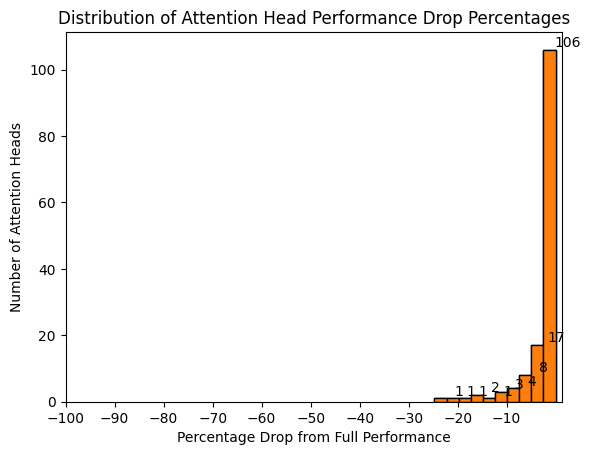

In [22]:
lh_scores_drop = {key: min(0, val-100) for key, val in lh_scores_t.items()}
scores = list(lh_scores_drop.values())
scores = [s.cpu().numpy() if isinstance(s, torch.Tensor) else s for s in scores]
plt.hist(scores, bins=10, edgecolor='black')
n, bins, patches = plt.hist(scores, bins=10, edgecolor='black')

for i in range(len(n)):
    plt.text(bins[i]+5, n[i], str(int(n[i])), va='bottom', ha='center')

plt.xticks(range(-100, 0, 10))
plt.xlabel('Percentage Drop from Full Performance')
plt.ylabel('Number of Attention Heads')
plt.title('Distribution of Attention Head Performance Drop Percentages')

plt.show()

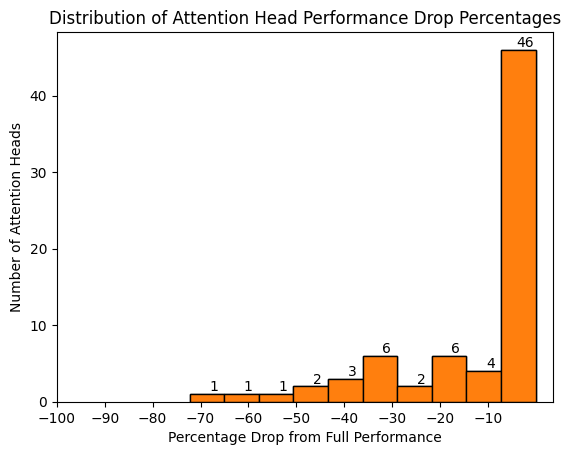

In [23]:
lh_scores_drop = {key: min(0, val-100) for key, val in lh_scores_s.items()}
scores = list(lh_scores_drop.values())
scores = [s.cpu().numpy() if isinstance(s, torch.Tensor) else s for s in scores]
plt.hist(scores, bins=10, edgecolor='black')
n, bins, patches = plt.hist(scores, bins=10, edgecolor='black')

for i in range(len(n)):
    plt.text(bins[i]+5, n[i], str(int(n[i])), va='bottom', ha='center')

plt.xticks(range(-100, 0, 10))
plt.xlabel('Percentage Drop from Full Performance')
plt.ylabel('Number of Attention Heads')
plt.title('Distribution of Attention Head Performance Drop Percentages')

plt.show()

In [24]:
def direct_ablate_single_mlp(
    model: HookedTransformer,
    dataset: Dataset,
    layer: int,
    orig_score: float,
    ablation_type="zero",
    print_output: bool = True
) -> float:
    model.reset_hooks(including_permanent=True)

    if ablation_type == "mean":
        _, cache = model.run_with_cache(
            dataset.toks.long(),
            return_type=None,
            names_filter=lambda name: name.endswith("mlp_out") and f"blocks.{layer}" in name
        )
        mlp_mean = cache[utils.get_act_name("mlp_out", layer)].mean(dim=0, keepdim=True)

    def hook_fn(mlp_out, hook):
        if hook.layer() == layer:
            if ablation_type == "zero":
                return torch.zeros_like(mlp_out)
            else:
                return mlp_mean.expand_as(mlp_out)
        return mlp_out

    model.add_hook(lambda name: name.endswith("mlp_out"), hook_fn, is_permanent=False)

    ablated_logits = model(dataset.toks)

    new_score = get_logit_diff(ablated_logits, ioi_dataset)

    percent_retained = 100 * (new_score / orig_score)

    if print_output:
        impact = 100 - percent_retained
        print(f"Layer {layer} MLP: Impact = {impact:.2f}%, Retained = {percent_retained:.2f}%")

    model.reset_hooks()
    return percent_retained


scores_mlp_t = []
scores_mlp_s = []

print("Analyzing teacher model MLPs...")
for layer in range(12):
    retained = max(0, direct_ablate_single_mlp(teacher, ioi_dataset, layer, orig_score_t, ablation_type="zero", print_output=False))
    try:
      scores_mlp_t.append((layer, -round(100 - retained.item(), 2)))
    except:
      scores_mlp_t.append((layer, -round(100 - retained, 2)))
    print(f"Completed Layer {layer} MLP: Retained = {retained:.2f}%")

print("\nAnalyzing student model MLPs...")
for layer in range(6):
    retained = direct_ablate_single_mlp(student, ioi_dataset, layer, orig_score_s, ablation_type="zero", print_output=False)
    try:
      scores_mlp_s.append((layer, -round(100 - retained.item(), 2)))
    except:
      scores_mlp_s.append((layer, -round(100 - retained, 2)))
    print(f"Completed Layer {layer} MLP: Retained = {retained:.2f}%")

Analyzing teacher model MLPs...
Completed Layer 0 MLP: Retained = 96.33%
Completed Layer 1 MLP: Retained = 78.87%
Completed Layer 2 MLP: Retained = 100.33%
Completed Layer 3 MLP: Retained = 102.21%
Completed Layer 4 MLP: Retained = 126.26%
Completed Layer 5 MLP: Retained = 90.92%
Completed Layer 6 MLP: Retained = 93.72%
Completed Layer 7 MLP: Retained = 112.61%
Completed Layer 8 MLP: Retained = 105.13%
Completed Layer 9 MLP: Retained = 96.81%
Completed Layer 10 MLP: Retained = 69.60%
Completed Layer 11 MLP: Retained = 100.13%

Analyzing student model MLPs...
Completed Layer 0 MLP: Retained = 556.07%
Completed Layer 1 MLP: Retained = 297.15%
Completed Layer 2 MLP: Retained = 367.34%
Completed Layer 3 MLP: Retained = 115.41%
Completed Layer 4 MLP: Retained = -562.85%
Completed Layer 5 MLP: Retained = 185.14%


In [25]:
scores_combined_t = scores_mlp_t + scores_attn_t
scores_combined_s = scores_mlp_s + scores_attn_s
print(scores_combined_t)
print(scores_combined_s)

[(0, -3.67), (1, -21.13), (2, 0.33), (3, 2.21), (4, 26.26), (5, -9.08), (6, -6.28), (7, 12.61), (8, 5.13), (9, -3.19), (10, -30.4), (11, 0.13), ((0, 5), -24.73), ((11, 8), -19.91), ((0, 6), -18.99), ((5, 8), -15.66), ((1, 6), -15.31), ((0, 7), -13.63), ((5, 9), -12.33), ((7, 3), -10.84), ((0, 0), -10.47), ((5, 0), -9.4), ((1, 5), -9.31), ((11, 4), -8.77), ((1, 0), -7.53), ((6, 8), -7.41), ((1, 10), -7.29), ((8, 5), -6.94), ((10, 9), -6.63), ((1, 11), -6.52), ((0, 8), -6.26), ((2, 5), -5.23), ((5, 3), -5.07), ((8, 8), -4.73), ((6, 5), -4.47), ((0, 3), -4.27), ((2, 6), -4.15), ((6, 11), -3.9), ((0, 4), -3.72), ((4, 1), -3.72), ((9, 7), -3.61), ((4, 9), -3.43), ((4, 4), -3.3), ((1, 7), -3.25), ((10, 4), -3.04), ((9, 3), -2.89), ((6, 4), -2.86), ((5, 2), -2.8), ((9, 4), -2.63), ((11, 6), -2.52), ((10, 1), -2.36), ((3, 2), -2.21), ((10, 11), -2.2), ((9, 11), -2.13), ((5, 7), -2.01), ((10, 2), -2.0), ((4, 10), -1.99), ((10, 7), -1.98), ((4, 8), -1.79), ((5, 5), -1.69), ((7, 8), -1.67), ((8, 

# Match components

In [26]:
import torch
import torch.nn.functional as F

sims = {}
max_vals_attn = {}

for student_layer in range(6):
    for student_head in range(12):
        curr_comb = (student_layer, student_head)
        if curr_comb not in max_vals_attn.keys():
            max_vals_attn[curr_comb] = (None, 0)
        for teacher_layer in range(12):
            for teacher_head in range(12):
                curr_s = local_cache_s["attn", student_layer][:, student_head].mean(dim=0)
                curr_t = local_cache_t["attn", teacher_layer][:, teacher_head].mean(dim=0)
                sim = torch.mean(F.cosine_similarity(curr_s.unsqueeze(1), curr_t.unsqueeze(1), dim=2))
                if sim > max_vals_attn[curr_comb][1]:
                    max_vals_attn[curr_comb] = ((teacher_layer, teacher_head), sim)
                sims[(student_layer, student_head, teacher_layer, teacher_head)] = sim


In [27]:
import numpy as np
from scipy.linalg import svd
from sklearn.metrics.pairwise import cosine_similarity

# computes similarity between eigenvectors of activation matrices from two layers.
def activation_eigenvector_similarity(layer1, layer2, k=3):
    acts1 = np.array(local_cache_t[f'blocks.{layer1}.hook_mlp_out'].cpu())
    acts2 = np.array(local_cache_s[f'blocks.{layer2}.hook_mlp_out'].cpu())

    acts1_flattened = acts1.reshape(-1, acts1.shape[-1])
    acts2_flattened = acts2.reshape(-1, acts2.shape[-1])

    cov1 = np.dot(acts1_flattened.T, acts1_flattened) / acts1_flattened.shape[0] # covariance matrices
    cov2 = np.dot(acts2_flattened.T, acts2_flattened) / acts2_flattened.shape[0]

    # get eigenvectors with singular value decomp
    U1, _, _ = svd(cov1)
    U2, _, _ = svd(cov2)
    U1_topk = U1[:, :k]
    U2_topk = U2[:, :k]

    similarity_matrix = cosine_similarity(U1_topk.T, U2_topk.T)
    avg_similarity = np.mean(similarity_matrix)

    return avg_similarity

In [28]:
sims_mlp = {}

for i in range(0, 6):
    for j in range(0, 12):
        curr_sim = abs(activation_eigenvector_similarity(j, i))
        sims_mlp[(i, j)] = curr_sim

In [29]:
# normalise MLP and attn. head similarities to be on the same scale

import torch
import numpy as np

mlp_keys = [k for k, v in sims_mlp.items() if v > 0]
mlp_values = np.array([v for v in sims_mlp.values() if v > 0])

attn_values = torch.tensor([v.item() for v in sims.values()])

mlp_mean, mlp_std = np.mean(mlp_values), np.std(mlp_values)
attn_mean, attn_std = torch.mean(attn_values), torch.std(attn_values)

if mlp_values.size > 0:
    mlp_min, mlp_max = np.min(mlp_values), np.max(mlp_values)
else:
    mlp_min, mlp_max = 0, 0
if attn_values.numel() > 0:
    attn_min, attn_max = torch.min(attn_values), torch.max(attn_values)
else:
    attn_min, attn_max = 0, 0

mlp_values_normalized = ((mlp_values - mlp_mean) / mlp_std) * attn_std.item() + attn_mean.item()

mlp_adjusted_values = mlp_values_normalized

sims_mlp_adjusted = {k: v for k, v in zip(mlp_keys, mlp_adjusted_values)}

sims_mlp_adjusted.update({k: 0 for k in sims_mlp if k not in sims_mlp_adjusted})

max_val = max(sims_mlp_adjusted.values())

if max_val == 0:
    sim_mlp_scaled = {key: 0 for key in sims_mlp_adjusted.keys()}
else:
    sim_mlp_scaled = {key: val / max_val for key, val in sims_mlp_adjusted.items()}

In [30]:
max_vals_mlp = {}

for (i, j), val in sims_mlp.items():
    if i not in max_vals_mlp or val > max_vals_mlp[i][1]:
        max_vals_mlp[i] = (j, val)

max_vals_mlp

{0: (1, 0.13220264),
 1: (5, 0.17380045),
 2: (5, 0.16502175),
 3: (5, 0.15884043),
 4: (9, 0.105078615),
 5: (10, 0.15294863)}

# Calculate model divergence

In [31]:
component_influence_teacher = scores_combined_t
component_influence_student = scores_combined_s
print(component_influence_teacher)
print(component_influence_student)

[(0, -3.67), (1, -21.13), (2, 0.33), (3, 2.21), (4, 26.26), (5, -9.08), (6, -6.28), (7, 12.61), (8, 5.13), (9, -3.19), (10, -30.4), (11, 0.13), ((0, 5), -24.73), ((11, 8), -19.91), ((0, 6), -18.99), ((5, 8), -15.66), ((1, 6), -15.31), ((0, 7), -13.63), ((5, 9), -12.33), ((7, 3), -10.84), ((0, 0), -10.47), ((5, 0), -9.4), ((1, 5), -9.31), ((11, 4), -8.77), ((1, 0), -7.53), ((6, 8), -7.41), ((1, 10), -7.29), ((8, 5), -6.94), ((10, 9), -6.63), ((1, 11), -6.52), ((0, 8), -6.26), ((2, 5), -5.23), ((5, 3), -5.07), ((8, 8), -4.73), ((6, 5), -4.47), ((0, 3), -4.27), ((2, 6), -4.15), ((6, 11), -3.9), ((0, 4), -3.72), ((4, 1), -3.72), ((9, 7), -3.61), ((4, 9), -3.43), ((4, 4), -3.3), ((1, 7), -3.25), ((10, 4), -3.04), ((9, 3), -2.89), ((6, 4), -2.86), ((5, 2), -2.8), ((9, 4), -2.63), ((11, 6), -2.52), ((10, 1), -2.36), ((3, 2), -2.21), ((10, 11), -2.2), ((9, 11), -2.13), ((5, 7), -2.01), ((10, 2), -2.0), ((4, 10), -1.99), ((10, 7), -1.98), ((4, 8), -1.79), ((5, 5), -1.69), ((7, 8), -1.67), ((8, 

In [32]:
attn_matches = max_vals_attn
mlp_matches = max_vals_mlp
print(sorted(attn_matches.items(), key=lambda x: x[1][1], reverse=True))
print(sorted(mlp_matches.items(), key=lambda x: x[1][1], reverse=True))

[((4, 1), ((4, 8), tensor(0.9996, device='cuda:0'))), ((5, 9), ((10, 6), tensor(0.9996, device='cuda:0'))), ((4, 11), ((9, 4), tensor(0.9994, device='cuda:0'))), ((4, 5), ((4, 4), tensor(0.9994, device='cuda:0'))), ((4, 6), ((10, 6), tensor(0.9994, device='cuda:0'))), ((3, 2), ((4, 8), tensor(0.9993, device='cuda:0'))), ((5, 6), ((11, 6), tensor(0.9993, device='cuda:0'))), ((5, 7), ((9, 4), tensor(0.9993, device='cuda:0'))), ((4, 9), ((10, 6), tensor(0.9992, device='cuda:0'))), ((2, 10), ((4, 4), tensor(0.9989, device='cuda:0'))), ((3, 6), ((9, 5), tensor(0.9989, device='cuda:0'))), ((5, 5), ((6, 3), tensor(0.9989, device='cuda:0'))), ((1, 11), ((4, 4), tensor(0.9989, device='cuda:0'))), ((4, 4), ((9, 4), tensor(0.9986, device='cuda:0'))), ((5, 2), ((11, 6), tensor(0.9983, device='cuda:0'))), ((2, 4), ((6, 6), tensor(0.9980, device='cuda:0'))), ((3, 1), ((11, 9), tensor(0.9979, device='cuda:0'))), ((1, 7), ((6, 6), tensor(0.9978, device='cuda:0'))), ((4, 2), ((8, 3), tensor(0.9975, dev

In [33]:
teacher_influences = {comp: abs(score) for comp, score in component_influence_teacher}
student_influences = {comp: abs(score) for comp, score in component_influence_student}
teacher_probs, student_probs = teacher_influences, student_influences

In [34]:

matched_pairs = {}

for (student_layer, student_head), ((teacher_layer, teacher_head), similarity) in attn_matches.items():
    matched_pairs[(teacher_layer, teacher_head)] = (student_layer, student_head)

for student_mlp, (teacher_mlp, similarity) in mlp_matches.items():
    matched_pairs[teacher_mlp] = student_mlp

teacher_matched_probs = []
student_matched_probs = []

for teacher_comp, student_comp in matched_pairs.items():
    if teacher_comp in teacher_probs and student_comp in student_probs:
        teacher_matched_probs.append(teacher_probs[teacher_comp])
        student_matched_probs.append(student_probs[student_comp])


In [35]:
matched_pairs

{(1, 8): (0, 11),
 (0, 1): (0, 5),
 (1, 9): (0, 9),
 (0, 4): (0, 4),
 (1, 0): (0, 7),
 (1, 4): (0, 8),
 (10, 8): (0, 10),
 (2, 0): (1, 0),
 (8, 0): (5, 4),
 (2, 2): (1, 2),
 (2, 3): (1, 3),
 (6, 0): (1, 4),
 (2, 5): (1, 5),
 (1, 7): (1, 6),
 (6, 6): (2, 4),
 (2, 8): (1, 8),
 (2, 9): (1, 9),
 (0, 0): (1, 10),
 (4, 4): (4, 5),
 (8, 7): (2, 0),
 (4, 1): (2, 3),
 (8, 2): (2, 2),
 (4, 3): (3, 8),
 (6, 7): (2, 6),
 (4, 7): (2, 7),
 (8, 3): (4, 2),
 (8, 5): (2, 9),
 (4, 11): (2, 11),
 (9, 10): (4, 10),
 (11, 9): (3, 1),
 (4, 8): (4, 1),
 (6, 5): (3, 3),
 (7, 4): (4, 0),
 (11, 3): (3, 5),
 (9, 5): (3, 6),
 (6, 1): (3, 11),
 (7, 9): (5, 10),
 (9, 4): (5, 7),
 (4, 0): (4, 3),
 (10, 6): (5, 9),
 (8, 8): (4, 7),
 (10, 0): (5, 1),
 (0, 11): (5, 0),
 (11, 6): (5, 6),
 (11, 11): (5, 3),
 (6, 3): (5, 5),
 (1, 10): (5, 8),
 (9, 0): (5, 11),
 1: 0,
 5: 3,
 9: 4,
 10: 5}

In [36]:
teacher_matched_probs

[5.84,
 14.41,
 1.65,
 3.72,
 7.53,
 1.21,
 0.96,
 23.63,
 7.55,
 6.3,
 8.91,
 0.02,
 5.23,
 3.25,
 9.99,
 11.96,
 10.8,
 10.47,
 3.3,
 0.93,
 3.72,
 1.59,
 2.89,
 1.57,
 5.98,
 2.67,
 6.94,
 7.32,
 0.65,
 1.49,
 1.79,
 4.47,
 3.26,
 0.71,
 1.7,
 2.71,
 0.05,
 2.63,
 0.59,
 1.45,
 4.73,
 0.05,
 4.61,
 2.52,
 2.02,
 1.11,
 7.29,
 0.09,
 21.13,
 9.08,
 3.19,
 30.4]

In [37]:
student_matched_probs

[82.19,
 100.98,
 115.93,
 8.12,
 72.28,
 37.33,
 109.62,
 20.04,
 1.55,
 15.56,
 11.49,
 17.68,
 18.69,
 24.41,
 14.75,
 10.67,
 54.74,
 23.35,
 31.32,
 12.9,
 32.44,
 25.24,
 19.77,
 48.8,
 61.37,
 4.47,
 9.73,
 17.06,
 18.54,
 110.59,
 6.67,
 31.18,
 0.25,
 12.34,
 58.49,
 22.94,
 104.01,
 8.38,
 9.72,
 31.19,
 152.1,
 40.79,
 42.54,
 40.01,
 10.49,
 4.47,
 8.89,
 16.81,
 456.07,
 15.41,
 662.85,
 85.14]

In [38]:
filtered_attn = [match for match in attn_matches.items()]

matched_attn_sim = set(attn_matches.items())
unmatched_attn_sim = set(attn_matches.items()) - set(filtered_attn)

filtered_attn_list = [x[0] for x in filtered_attn]

In [39]:
filtered_mlp = [match for match in mlp_matches.items()]

matched_mlp_sim = set(filtered_mlp)
unmatched_mlp_sim = set(mlp_matches.items()) - set(filtered_mlp)

filtered_mlp_list = [a[0] for a in filtered_mlp]
filtered_mlp_list

[0, 1, 2, 3, 4, 5]

In [40]:
matched = list(matched_attn_sim) + list(matched_mlp_sim)
unmatched = list(unmatched_attn_sim) + list(unmatched_mlp_sim)

In [41]:
all_sims = matched + unmatched
matched_norm = [
    (entry[0], (entry[1][0], entry[1][1]))
    for entry in matched
]

unmatched_norm = [
    (entry[0], (entry[1][0], entry[1][1]))
    for entry in unmatched
]

In [42]:
student_matched = []
student_unmatched = []

for student_comp, (teacher_comp, similarity) in matched_norm:
    try:
        student_matched.append((student_probs[student_comp], teacher_probs[teacher_comp], similarity.item()))
    except:
        student_matched.append((student_probs[student_comp], teacher_probs[teacher_comp], similarity))

for student_comp, (teacher_comp, similarity) in unmatched_norm:
    try:
        student_unmatched.append((student_probs[student_comp], teacher_probs[teacher_comp], similarity.item()))
    except:
        student_unmatched.append((student_probs[student_comp], teacher_probs[teacher_comp], similarity))

In [43]:
all_student = student_unmatched + student_matched

In [44]:
print(f"Teacher performance: {orig_score_t}")
print(f"Student performance: {orig_score_s}")
print(f"Performance drop: {orig_score_t - orig_score_s}")
print(f"Mean performance: {(orig_score_t + orig_score_s) / 2}")

Teacher performance: -7.0053629875183105
Student performance: -0.23112374544143677
Performance drop: -6.774239242076874
Mean performance: -3.6182433664798737


In [45]:
# scale influences by length of pairs
all_student_scaled = all_student.copy()

for i in range(len(all_student)):
    (I_S, I_T, S) = all_student[i]
    all_student_scaled[i] = (I_S * len(all_student), I_T * len(all_student), S)

all_student_normalised = all_student.copy()
sum_I_T = sum(I_T for _, I_T, _ in all_student)
sum_I_S = sum(I_S for I_S, _, _ in all_student)
for i in range(len(all_student_normalised)):
    (I_S, I_T, S) = all_student[i]
    all_student_normalised[i] = (I_S / sum_I_S, I_T / sum_I_T, S)
    
# normalise scaled influences
all_student_scaled_normalised = all_student_normalised.copy()
sum_I_T = sum(I_T for _, I_T, _ in all_student_normalised)
sum_I_S = sum(I_S for I_S, _, _ in all_student_normalised)
for i in range(len(all_student_scaled_normalised)):
    (I_S, I_T, S) = all_student_normalised[i]
    all_student_scaled_normalised[i] = (I_S * len(all_student), I_T * len(all_student), S)

all_student_scaled_normalised

[(0.9074308055403248, 0.3111201443052768, 0.996961772441864),
 (0.3287577180728063, 0.003963313940194608, 0.962141215801239),
 (0.31722888406799066, 1.4505729021112268, 0.9560507535934448),
 (2.056409278375093, 0.29526688854449834, 0.9978733062744141),
 (0.6071232746084346, 0.6460201722517213, 0.996532142162323),
 (0.7584857081555297, 0.009908284850486523, 0.9973386526107788),
 (0.45390135170572404, 0.6440385152816239, 0.9581529498100281),
 (0.22946098648294283, 0.1406976448769086, 0.9881876707077026),
 (0.02882208501203901, 1.4961510124234647, 0.9859961867332458),
 (0.1558252080005722, 0.521175783135591, 0.9992665648460388),
 (0.6941473764512363, 0.23978049338177382, 0.9816961288452148),
 (0.9146828140272251, 1.979675313127207, 0.9978430867195129),
 (2.8282833098910536, 0.937323746856025, 0.9898607134819031),
 (0.31258016067895206, 0.01783491273087574, 0.9945087432861328),
 (0.08311917419600927, 0.2199639236808008, 0.9988729357719421),
 (0.5799747300164495, 0.2873402606641091, 0.99956

In [46]:
def alignment(pairs):
    return sum(S * (1 - abs(I_S - I_T)) for I_S, I_T, S in pairs) / len(pairs)

In [49]:
print(f"Alignment score: {round(alignment(all_student_normalised), 2)}")

Alignment score: 0.9
